In [35]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Definition of the dataset and growth parameters:

In [ ]:
# maximum number of read pairs in each sample of the time series (approximate)
n_reads = 10_000_000
# skip samples with less than min_reads
min_reads = 7_500_000
# number of samples in the time series
n_samples = 20
# relative abundance of the pathogen in the whole sample
# if 100% of the contibuting population was infected (in %)
# corresponds to "conversion factor B between the public health indicator and the virus’ relative abundance"
# from https://doi.org/10.1101/2023.12.22.23300450
conversion_factor = 0.0001
# generation time (in days)
generation_time = 3
# reproduction number
r = 1.15
# prevalence of infected individuals on day 0 (in % of the contributing population)
i0 = 0.001



Location of the input files:

In [91]:
background_data_info_path = "results/SraRunTable_filtered_ordered.csv"
background_data_path = "results/raw"
multiqc_data_path = "results/multiqc/multiqc_data/multiqc_general_stats.txt"
pathogen_data_path = "results/pathogen/nipah"

Import background data information:

In [ ]:
## Import the background data information
background_df=pandas.read_csv(background_data_info_path)
# select the sample name and collection date
background_df = background_df[["Sample Name", "Collection_Date"]]
background_df["Collection_Date"] = pandas.to_datetime(background_df["Collection_Date"], format="%Y-%m-%d")

original_samples_list = background_df["Sample Name"].tolist()

Find the number of reads in each background data file in fastqc results:

In [124]:
# find total number of reads for each sample in multiqc report and 
multiqc_df = pandas.read_csv(multiqc_data_path, sep="\t")
multiqc_df["Sample shortname"]=multiqc_df["Sample"].str[:-2]
# select the sample name and the number of reads
multiqc_df = multiqc_df[["Sample shortname", "FastQC_mqc-generalstats-fastqc-total_sequences"]]
# modify the read column
multiqc_df = multiqc_df.rename(columns={"FastQC_mqc-generalstats-fastqc-total_sequences": "Total Reads"})
multiqc_df["Total Reads"] = multiqc_df["Total Reads"].astype(int)
multiqc_df = multiqc_df.drop_duplicates()

# merge the two dataframes
background_df = background_df.merge(multiqc_df, left_on="Sample Name", right_on="Sample shortname")

# check which samples don't have a corresponding multiqc report
missing_samples = [sample for sample in original_samples_list if sample not in background_df["Sample Name"].tolist()]
print("Samples missing in the multiqc report: ", missing_samples)

# select the samples with more than min_reads
print("Samples with fewer than", min_reads, "reads:" , background_df[background_df["Total Reads"] <= min_reads]["Sample Name"].tolist())
background_df = background_df[background_df["Total Reads"] > min_reads]

# create column with days since the first sample and the order of the samples
background_df["Days"] = (background_df["Collection_Date"] - background_df["Collection_Date"].min()).dt.days




Samples missing in the multiqc report:  ['HTP_10_13_2020_INF_unenriched', 'HTP_10_20_2020_INF_unenriched', 'HTP_11_17_2020_INF_unenriched', 'HTP_11_24_2020_INF_unenriched', 'HTP_12_01_2020_INF_unenriched', 'HTP_12_04_2020_INF_unenriched', 'HTP_2_4_21', 'HTP_2_7_21', 'HTP_2_9_21', 'HTP_2_23_21', 'HTP_3_16_21', 'HTP_3_31_2021', 'HTP_5_2_2021', 'HTP_5_24_2021', 'HTP_6_20_2021']
Samples with fewer than 7500000 reads: ['HTP_8_11_2020_INF_unenriched', 'HTP_8_18_2020_INF_unenriched', 'HTP_8_25_2020_INF_unenriched', 'HTP_9_01_2020_INF_unenriched', 'HTP_9_08_2020_INF_unenriched', 'HTP_9_15_2020_INF_unenriched', 'HTP_10_02_2020_INF_unenriched', 'HTP_10_27_2020_INF_unenriched']


In [125]:
# calculate the infected population
background_df["Infected"] = i0*r**(background_df["Days"]/generation_time)
background_df["Infected"] = background_df["Infected"].clip(0, 100)
# calculate the relative abundance of the pathogen in the sample
background_df["Calculated Abundance"] = conversion_factor*background_df["Infected"]
# calculate the number of reads of the pathogen in the sample
# by selecting from a Poisson distribution
background_df["Background Reads"]= np.random.poisson(n_reads*(1-background_df["Calculated Abundance"]))
# compare the number of background reads to the total number of reads
background_df["Background Reads"] = np.minimum(background_df["Background Reads"], background_df["Total Reads"])
# calculate the number of reads of the pathogen in each sample
def calculate_lambda(background_reads, pathogen_abundance):
    return background_reads*pathogen_abundance/(100-pathogen_abundance)
background_df["Lambda"] = calculate_lambda(background_df["Background Reads"], background_df["Calculated Abundance"])
background_df["Pathogen Reads"] = np.random.poisson(background_df["Lambda"])
# calculate the actual abundance
background_df["Actual Abundance"] = 100*background_df["Pathogen Reads"]/(background_df["Pathogen Reads"]+background_df["Background Reads"])

# take only the some of the samples
background_df = background_df[:n_samples]


Visualize the growth:

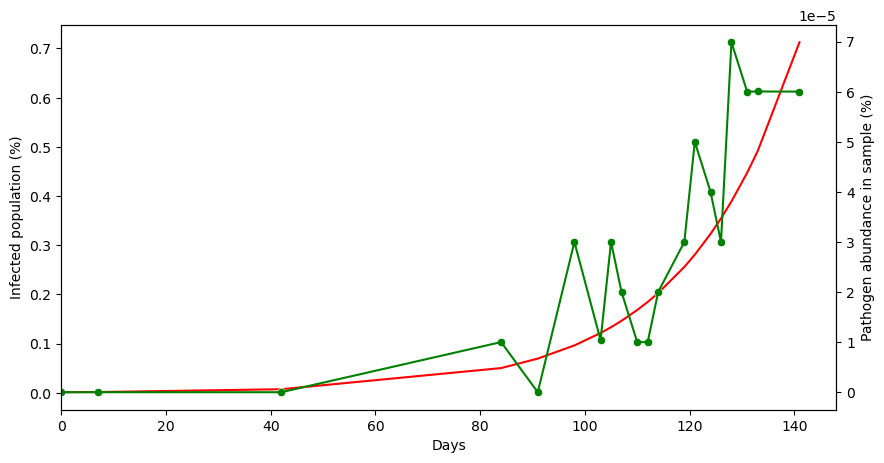

In [126]:
# plot the number of pathogen reads in the samples
# plot the calculated abundance of the pathogen in the samples on the same plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=background_df, x="Days", y="Infected", color="red")
plt.ylabel("Infected population (%)")
plt.twinx()
sns.lineplot(data=background_df, x="Days", y="Actual Abundance", color="green")
plt.xlabel("Days")
plt.ylabel("Pathogen abundance in sample (%)")
# add points to the plot
sns.scatterplot(data=background_df, x="Days", y="Actual Abundance", color="green")
plt.xlim(0, )
plt.show()




Export the data to a table for subsampling: 

In [127]:
# export the table
background_df.to_csv("results/subsampling_table.tsv", index=False, sep="\t")
